### dev.akademi2018 - Seleme Topuz

In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import tree, ensemble, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
df = pd.read_json('all_data 3.json').set_index('id') # use 'id' column for indexing

In [8]:
whole_data_count = len(df)

In [9]:
df.head(1)

,ad_bid_price_kurus,ad_call_to_action,ad_daily_budget_kurus,ad_description,ad_id,ad_title,event_category,event_date,event_type,viewer_birt_year,viewer_education,viewer_gender,viewer_job,viewer_marital_status,viewer_user_city,viewer_user_id
id,,,,,,,,,,,,,,,,
1,1000.0,8b36e9 6f041af,200000.0,8b36e9 ee1a793907 0ba 29c8ae3130 529230e5a4a 6...,10,6e809498e59 8b36e9 509f987 cc77d627 1650f9 d6badc,İkinci El ve Sıfır Alışveriş,1.514756e+09,IMPRESSION,1975.0,Üniversite,E,Özel Sektör,Evli,İstanbul,3622


# Data Cleaning

### Unnecessary Data

- If a document's event_type is CLICK, then the previous document where all the columns are same with CLICK'ed one but only event_type. We can delete that document with event_type 'IMPRESSION' since the ad worked and I will analyze IMPRESSION documents as failures.

In [10]:
click_indices = df[df.event_type == 'CLICK'].index
drop_indices = list(map(lambda x: x-1, click_indices))
df.drop(drop_indices, inplace=True)

### Null Check

In [11]:
for column in df.columns:
    print(column, len(df[pd.isna(df[column])]))

ad_bid_price_kurus 50
ad_call_to_action 23
ad_daily_budget_kurus 38
ad_description 32
ad_id 0
ad_title 46
event_category 32
event_date 43
event_type 37
viewer_birt_year 40
viewer_education 43
viewer_gender 32
viewer_job 28
viewer_marital_status 39
viewer_user_city 32
viewer_user_id 0


- Data has some corrupt data, this may imply that there are some bugs, but that's another issue for now.
- Since the size data including null columns is quite small comparing to whole document count, I will just delete those rows and keep analyzing.

In [12]:
before_null_purify = df.shape[0]

In [13]:
for column in df.columns:
    df.drop(df[pd.isna(df[column])].index, inplace=True)

In [14]:
after_null_purify = df.shape[0]

In [15]:
total_null_deleted = before_null_purify-after_null_purify

In [16]:
total_null_deleted, (total_null_deleted / whole_data_count) * 100

(515, 0.5071043847297576)

522 documents are deleted due to corruption. That's approximately 0.5% of whole data.

### Zero Check

In [17]:
for column in df.columns:
    if df[column].dtype == np.object:
        print(column, len(df[df[column]==""]))
    else:
        print(column, len(df[df[column]==0]))

ad_bid_price_kurus 28
ad_call_to_action 41
ad_daily_budget_kurus 40
ad_description 46
ad_id 0
ad_title 36
event_category 33
event_date 48
event_type 30
viewer_birt_year 46
viewer_education 31
viewer_gender 34
viewer_job 36
viewer_marital_status 40
viewer_user_city 39
viewer_user_id 0


In [18]:
before_zero_purify = df.shape[0]

In [19]:
for column in df.columns:
    if df[column].dtype == np.object:
        df.drop(df[df[column]==""].index, inplace=True)
    else:
        df.drop(df[df[column]==0].index, inplace=True)

In [20]:
after_zero_purify = df.shape[0]

In [21]:
total_zero_deleted = before_zero_purify-after_zero_purify

In [22]:
(total_zero_deleted, (total_zero_deleted / whole_data_count) * 100)

(528, 0.5199050779365283)

534 documents are deleted due to corruption. That's approximately 0.5% of whole data.

# Feature Extraction

- This function will be used in the next part where I will be preprocessing the data. This function splits words in a string column, let's say 'the description'. After capturing all unique words in each descriptions, the function check if each word is included in a description or not so that we could know that a description store a special word. This is basically special version of pandas.get_dummies function. This simply extracts features from raw string data.

In [23]:
def get_word_dummies(df, column):
    txed_df = pd.DataFrame(index=df.index)
    splitted = pd.Series(df[column].str.split())
    # get all words in a set
    word_set = set()
    for slist in list(splitted):
        word_set.update(slist)
    # iterate over all words and mark if a row contains it
    for word in word_set:
        srs = pd.Series(splitted.apply(lambda x: word in x)).replace(True, 1)
        txed_df[word] = srs
    return txed_df

# Preprocessing

In [24]:
NUMBERS = ['ad_bid_price_kurus', 'ad_daily_budget_kurus', 'event_date', 'viewer_birt_year'] # scaler
CATEGOS_NUM = ['ad_id', 'viewer_user_id'] # one hot
CATEGOS_STR = ['event_category', 'viewer_education', 'viewer_gender', 'viewer_job', 'viewer_user_city', 'viewer_marital_status'] # dummies
STRINGS = ['ad_call_to_action', 'ad_description', 'ad_title'] # split
LABEL = 'event_type'

In [25]:
txed_data = {} # transformed data
dummy_cats = {} # stores names of each categorical feature column

In [26]:
for number_column in NUMBERS:
    inpt = np.array(df[number_column]).reshape(-1,1)
    txed = StandardScaler().fit_transform(inpt)
    txed_data[number_column] = txed

In [27]:
for categos_num_column in CATEGOS_NUM:
    inpt = np.array(df[categos_num_column]).reshape(-1,1)
    txed = OneHotEncoder(sparse=False).fit_transform(inpt)
    txed_data[categos_num_column] = txed

In [28]:
for categos_str_column in CATEGOS_STR:
    txed = pd.get_dummies(df[categos_str_column])
    dummy_cats[categos_str_column] = txed.columns
    txed_data[categos_str_column] = np.array(txed)

In [29]:
for string_column in STRINGS:
    txed = get_word_dummies(df, string_column)
    dummy_cats[string_column] = txed.columns
    txed_data[string_column] = np.array(txed)

In [30]:
# this is our label column, 1 means CLICK, 0 means IMPRESSION
txed = pd.Series(df.event_type == 'CLICK').replace(True, 1)
txed_data['event_type'] = np.array(txed)

In [31]:
def prepare_data_set(features):
    feature_counts = [] # stores column count for each feature preprocessed
    feature_count = 0
    data_to_stack = []
    column_names = []
    
    for feature in features:
        data_to_stack.append(txed_data[feature])
        feature_count += txed_data[feature].shape[1]
        feature_counts.append(feature_count)
        
        if feature in dummy_cats:
            column_names.append(list(dummy_cats[feature]))
        else:
            column_names.append(feature)
        
    data_set = np.hstack(data_to_stack)
    return data_set, column_names, feature_counts

# Derivations with Machine Learning

- I decided to use "Decision Tree" in most of my analyses as trees and their ensembles are very informative. They already generete feature importances for us.

In [32]:
y = txed_data['event_type']

### Call to Action Words

- Let's analyze which words in ad_call_to_action field have most impact on the outcome.

In [33]:
X, column_names, feature_counts = prepare_data_set(['ad_call_to_action'])

dtc = tree.DecisionTreeClassifier()
dtc.fit(X, y)

importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]

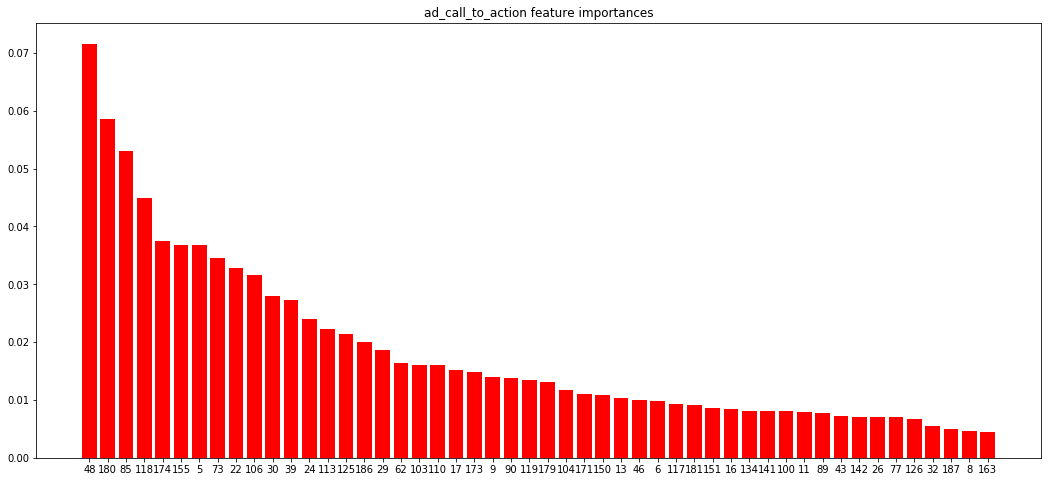

In [34]:
# Plot the feature importances of the forest
top_n = 50
plt.figure(figsize=(18,8))
plt.title("ad_call_to_action feature importances")
plt.bar(range(X.shape[1])[:top_n], importances[indices][:top_n],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:top_n], indices[:top_n])
plt.show()

- These are top 10 words from the most important to the least important in 'ad_call_to_action' field learnt by the decision tree.

In [35]:
dict(zip(range(1,11), np.array(column_names[0])[indices[:10]]))

{1: 'c5221',
 2: '230c29',
 3: '0917',
 4: '78869f',
 5: '5c1453',
 6: 'df10',
 7: '73f3465',
 8: '3612',
 9: 'bd6ad4035bc35',
 10: 'd70'}

### Words in Ad Descriptions

In [36]:
X, column_names, feature_counts = prepare_data_set(['ad_description'])

dtc = tree.DecisionTreeClassifier()
dtc.fit(X, y)

importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]

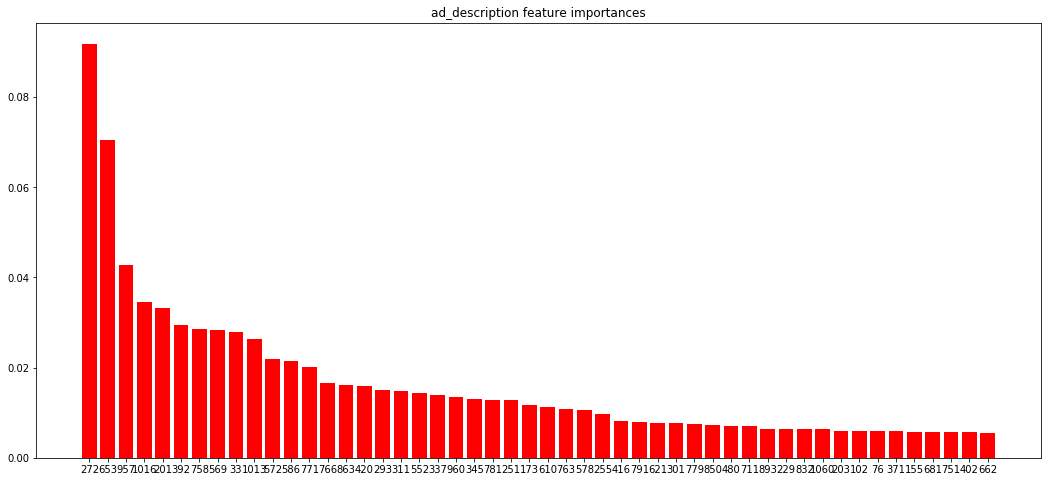

In [37]:
# Plot the feature importances of the forest
top_n = 50
plt.figure(figsize=(18,8))
plt.title("ad_description feature importances")
plt.bar(range(X.shape[1])[:top_n], importances[indices][:top_n],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:top_n], indices[:top_n])
plt.show()

- These are top 10 words from the most important to the least important in 'ad_description' field learnt by the decision tree.

In [38]:
dict(zip(range(1,11), np.array(column_names[0])[indices[:10]]))

{1: '6950810f',
 2: '2bfc53',
 3: 'c5221',
 4: 'f275b',
 5: 'd1a4e',
 6: '1fbd',
 7: '26831b9f',
 8: '89c674e9113',
 9: '2c8aa',
 10: '95cbcd2'}

### Words in Ad Title

In [39]:
X, column_names, feature_counts = prepare_data_set(['ad_title'])

dtc = tree.DecisionTreeClassifier()
dtc.fit(X, y)

importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]

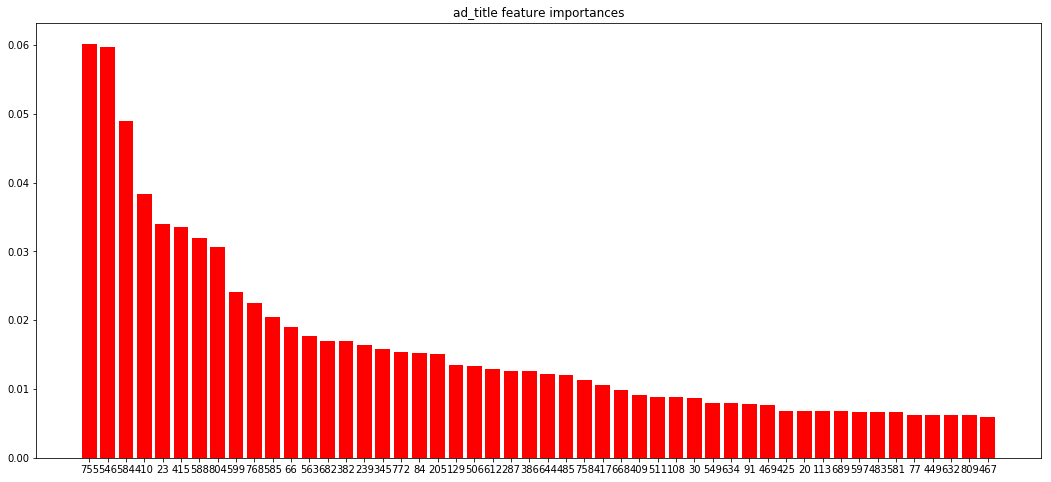

In [40]:
# Plot the feature importances of the forest
top_n = 50
plt.figure(figsize=(18,8))
plt.title("ad_title feature importances")
plt.bar(range(X.shape[1])[:top_n], importances[indices][:top_n],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:top_n], indices[:top_n])
plt.show()

- These are top 10 words from the most important to the least important in 'ad_title' field learnt by the decision tree.

In [41]:
dict(zip(range(1,11), np.array(column_names[0])[indices[:10]]))

{1: 'f275b',
 2: 'a9',
 3: '16e',
 4: '89c674e9113',
 5: '7dddce14',
 6: '1af9e409',
 7: '7998422bce7',
 8: '7a331bcb3',
 9: '7a9',
 10: '9ee92'}

### Viewer Information

In [42]:
viewer_features = ['viewer_birt_year', 'viewer_education', 'viewer_gender',
                                            'viewer_job', 'viewer_marital_status', 'viewer_user_city']
X, column_names, feature_counts = prepare_data_set(viewer_features)

dtc = tree.DecisionTreeClassifier()
dtc.fit(X, y)

importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]

In [44]:
totals = []
prev = 0
for feature_count in feature_counts:
    totals.append(sum(dtc.feature_importances_[prev:feature_count]))
    prev = feature_count
dict(zip(viewer_features, totals))

{'viewer_birt_year': 0.3387535764176388,
 'viewer_education': 0.12063175836595613,
 'viewer_gender': 0.05972447685693553,
 'viewer_job': 0.13671061040911578,
 'viewer_marital_status': 0.12315765097823084,
 'viewer_user_city': 0.22102192697212283}

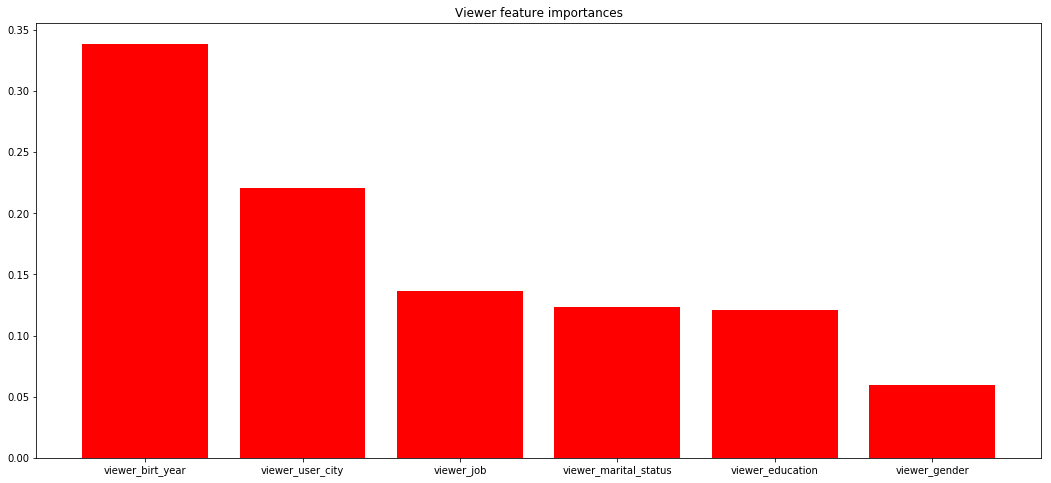

In [45]:
importances = np.array(totals)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
top_n = 6
plt.figure(figsize=(18,8))
plt.title("Viewer feature importances")
plt.bar(range(X.shape[1])[:top_n], importances[indices][:top_n],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:top_n], np.array(viewer_features)[indices[:top_n]])
plt.show()

- We can see from here that, marital status and birth year do not matter that much comparing to the city and the gender of the view.

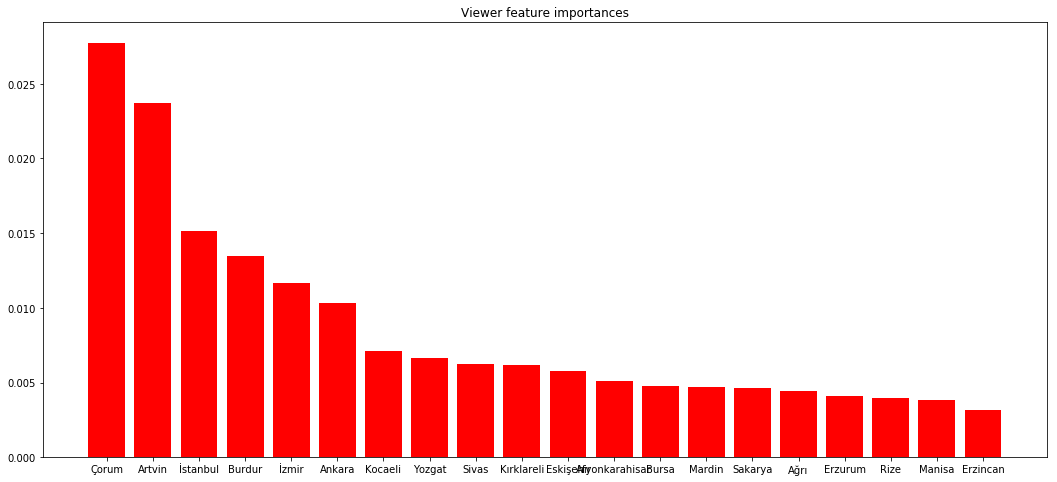

In [46]:
i = 5 # 5th feature is indicating city
importances = np.array(dtc.feature_importances_[feature_counts[i-1]+1:feature_counts[i]+1])
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
top_n = 20
plt.figure(figsize=(18,8))
plt.title("Viewer feature importances")
plt.bar(range(X.shape[1])[:top_n], importances[indices][:top_n],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:top_n], np.array(column_names[i])[indices[:top_n]])
plt.show()

- We can see overall top-20 city importance on clicked ads.

### Importance of the other features

In [47]:
def train_and_print_importances(features):
    X, column_names, feature_counts = prepare_data_set(features)
    rfc = tree.DecisionTreeClassifier()
    rfc.fit(X, y)
    totals = []
    prev = 0
    for feature_count in feature_counts:
        totals.append(sum(rfc.feature_importances_[prev:feature_count]))
        prev = feature_count
    return(list(zip(features, totals)))

In [48]:
train_and_print_importances(['ad_bid_price_kurus', 'ad_daily_budget_kurus', 'event_category', 'event_date'])

[('ad_bid_price_kurus', 0.01423342927649856),
 ('ad_daily_budget_kurus', 0.012378829477214496),
 ('event_category', 0.006211997034429866),
 ('event_date', 0.9671757442118571)]

- event_date is surprisingly high. We need to analyze this.

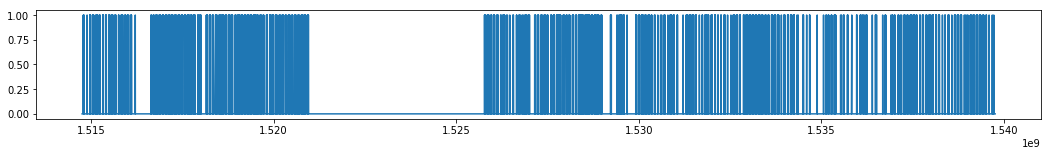

In [50]:
plt.figure(figsize=(18,2))
plt.plot(df.event_date, txed)

- It turns out there is a gap in data considering chronogically.

In [ ]:
rfc = tree.DecisionTreeClassifier()
rfc.fit(X, y)

In [ ]:
totals = []
prev = 0
for feature_count in feature_counts:
    totals.append(sum(rfc.feature_importances_[prev:feature_count]))
    prev = feature_count

In [99]:
features = ['ad_bid_price_kurus', 'ad_call_to_action', 'ad_daily_budget_kurus', 'event_category', 
            'viewer_birt_year', 'viewer_education', 'viewer_gender',
            'viewer_job', 'viewer_marital_status']
X, column_names, feature_counts = prepare_data_set(features)

In [100]:
weights = {0: 1, 1: 75}
sample_weights = [weights[x] for x in y]

In [101]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(X, y, sample_weights, test_size=0.2, random_state=42)

In [102]:
lr = linear_model.LogisticRegression(tol=1e-10, max_iter=10000)

In [103]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-10,
          verbose=0, warm_start=False)

In [104]:
lr.score(X_test, y_test, sample_weights_test)

0.5

In [ ]:
print(metrics.classification_report(rfc.predict(X_test), y_test))

'viewer_user_id' 6k
'ad_id' 200

# debug

In [ ]:
splitted = pd.Series(df['ad_call_to_action'].str.split())
a=df.loc[np.array(splitted.apply(lambda x: '230c29' in x))]
a[a.event_type=='CLICK'].shape